# Assignment 2: Model Creation with SciKit-learn

In this notebook, you will work through a series of exercises designed to deepen your understanding of model creation using SciKit-learn. The assignment requires code-based solutions—**manually computed or hard-coded results will not be accepted**. 

### Instructions:
- Write your solutions in the provided cells without altering or removing the test cells.
- Upon completion, submit the notebook in **.ipynb** format through Moodle.

In addition to the coding exercises, there are several open-ended questions that require thoughtful responses. Your answers should be thoroughly **justified** using: (a) Python code, (b) performance metrics, and (c) visualizations. Unsubstantiated responses will receive lower evaluations, so ensure your answers are supported with clear evidence.

In [1]:
# IMPORTANT: DO NOT MODIFY OR DELETE THIS CELL.
# Do not add any cells before this one.
# This cell must remain as the first cell in your notebook for proper functionality.


<div class="alert alert-warning">

The following cell contains two functions for result visualization. **DO NOT MODIFY** them.

You are allowed to reuse parts of this code for the open-ended questions,  but ensure both functions remain unchanged in their original form.

- The `plot_decision_surface` function generates a scatter plot of the training data (as circles) and test data (as diamonds), along with the model's decision boundary.
  
- The `plot_parallel_coordinates` function visualizes the accuracy, precision, recall, and F1-score in relation to the gamma parameter of a Support Vector Machine classifier.
</div>

In [ ]:
# IMPORTANT: DO NOT MODIFY OR DELETE THIS CELL.
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import set_config
import plotly.graph_objects as go

set_config(transform_output="pandas")

def plot_decision_surface(X_train, y_train, X_test=None, y_test=None, model=None, show_points=True, title=None):
    if X_train.shape[1] != 2:
        raise ValueError(f'Incorrect shape {X.shape}, can only plot 2D datasets')

    # just plot the dataset first
    cm = 'coolwarm'
    cm_bright = ListedColormap(['#0000FF', '#FF0000', ])

    fig, ax = plt.subplots()

    if model is not None:
        x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
        y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                             np.arange(y_min, y_max, 0.01))
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        X_mesh = np.c_[xx.ravel(), yy.ravel()]
        try:
            Z = model.decision_function(X_mesh)
        except AttributeError:
            try:
                Z = model.predict_proba(X_mesh)[:, 1]
                if Z.min() >= 0:
                    Z = Z * 2 - 1
            except AttributeError:
                Z = model.predict(X_mesh)
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        Z_max = np.abs(Z).max()
        cs_contourf = ax.contourf(xx, yy, Z, levels=10, cmap=cm, alpha=.8, vmin=-Z_max, vmax=Z_max, )
        cs_contour = ax.contour(xx, yy, Z, [-1, 0, 1], linewidths=[1, 2, 1], alpha=0.5,
                                colors=('#0000FF', 'gray', '#FF0000'))

        # Make a colorbar for the ContourSet returned by the contourf call.
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)

        cbar = ax.figure.colorbar(cs_contourf, cax=cax)
        # Add the contour line levels to the colorbar
        try:
            cbar.add_lines(cs_contour)
        except Exception:
            pass
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())

    if show_points:
        # # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   #edgecolors='k', 
                   alpha=0.25)
        # ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
        #                edgecolors='k', alpha=0.6, s=140)
        if X_test is not None:
            # and testing points
            ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                       #edgecolors='k',
                       # s=100,
                       marker='D')

    ax.set_xticks(())
    ax.set_yticks(())

    ax.set_aspect('equal', 'box')
    if title is not None:
        ax.set_title(title)
    plt.show()


def plot_parallel_coordinates(df, svm_models, title):
    df = df.copy()
    with pd.option_context('future.no_silent_downcasting', True):
        df = df.replace({'gamma': {'scale': svm_models['scale']._gamma}})
    dimensions = [
        dict(range=[0, 1],
             label='Accuracy', values=df['accuracy']),
        dict(range=[0, df['gamma'].max()],
             label='Gamma', values=df['gamma']),
        dict(range=[0, 1],
             label='Precision 0', values=df['precision_class_0']),
        dict(range=[0, 1],
             label='Precision 1', values=df['precision_class_1']),
        dict(range=[0, 1],
             label='Recall 0', values=df['recall_class_0']),
        dict(range=[0, 1],
             label='Recall 1', values=df['recall_class_1']),
        dict(range=[0, 1],
             label='F1 0', values=df['f1_class_0']),
        dict(range=[0, 1],
             label='F1 1', values=df['f1_class_1'])
    ]
    if 'dataset_size' in df.columns:
        dimensions.insert(1, dict(range=[0, 2500],
                                   label='Dataset size', values=df['dataset_size'],
                                   tickvals=[250, 2500],
                                   ticktext=['250', '2500']))

    
    fig = go.Figure(
        go.Parcoords(
            line=dict(color=df.index.to_list(), colorscale='Plasma_r', showscale=False),
            dimensions=dimensions
        ))
    fig.update_layout(
        title=title,
        font_size=10
    )
    fig.show()


<div class="alert alert-info"><b>Exercise 1: Synthetic dataset generation</b>

Write code to generate the feature matrix `X` and the target array `y` using the `make_moons` function from the `sklearn.datasets` module with the parameters: `n_samples=250`, `noise=0.1`, and `random_state=42`. After creating the dataset, call `plot_decision_surface(X, y)` to visualize the data distribution.

<br><i>[0.5 points]</i>
</div>
<div class="alert alert-warning">

Python is case-sensitive, so ensure your code matches the required capitalization.

</div>

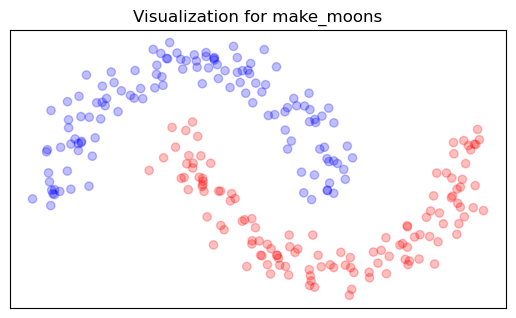

In [3]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=250, noise=0.1, random_state=42)

plot_decision_surface(X, y, title="Visualization for make_moons")


DO NOT TOUCH BELOW

In [4]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 1: Train-test split </b>

Write code to split the generated dataset into training and testing sets, allocating 80% of the data for training and 20% for testing. Use `random_state=42` to ensure reproducibility. Store the resulting arrays in `X_train`, `X_test`, `y_train`, and `y_test`. After creating the dataset, call again `plot_decision_surface(X_train, y_train, X_test, y_test)` to visualize the train and test data distribution.
<br><i>[0.25 points]</i>
</div>

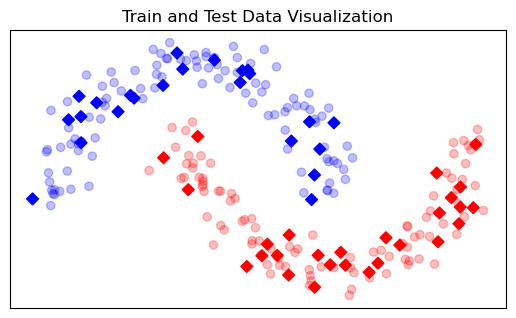

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plot_decision_surface(X_train, y_train, X_test, y_test, title="Train and Test Data Visualization")

DO NOT TOUCH BELOW

In [6]:
# LEAVE BLANK

In [7]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 2: Logistic regression model creation</b>

Write code to fit a logistic regression model to the training data and store the model in a variable called `logistic`. Then, calculate the accuracy for both the training and testing sets, and store the results in `train_accuracy` and `test_accuracy`, respectively.

<br><i>[0.5 points]</i>
</div>


In [8]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logistic = LogisticRegression()
logistic.fit(X_train, y_train)

y_train_pred = logistic.predict(X_train)
y_test_pred = logistic.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Display the accuracy results
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

Training Accuracy: 0.855
Testing Accuracy: 0.9


DO NOT TOUCH BELOW

In [9]:
# LEAVE BLANK

In [10]:
# LEAVE BLANK

In [11]:
# LEAVE BLANK

In [12]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 3: Explain logistic regression decision boundary</b>

Provide substantiated answers to the following questions:

- What issues, if any, do you observe in the model’s performance or behavior? Is the decision boundary well-suited to the underlying structure of the data?
- Are there specific areas where the model underperforms? If so, do you believe accuracy alone is an adequate metric to evaluate the model’s performance?
- Do you think logistic regression is an appropriate model for this dataset? Why or why not?
- Does the model appear to overfit or underfit the data? What evidence supports your conclusion?

<br><i>[0.5 points]</i>
</div>

DO NOT TOUCH BELOW

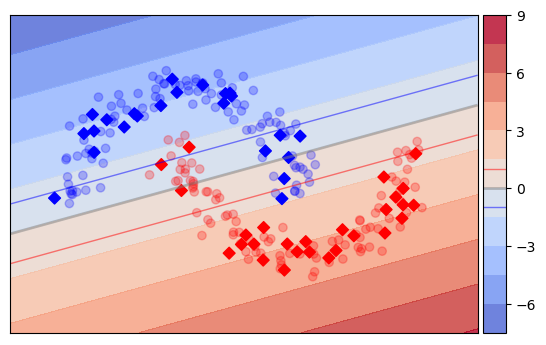

In [13]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_decision_surface(X_train, y_train, X_test, y_test, logistic)

#### Part 1: What issues, if any, do you observe in the model’s performance or behavior? Is the decision boundary well-suited to the underlying structure of the data?


**From Visualization:** In the decision boundary plot, we can observe that the logistic regression model creates a linear decision boundary. This boundary doesn’t align well with the underlying structure of the data, which consists of two non-linear, moon-shaped distributions.

**Conclusion:** The linear decision boundary of logistic regression isn’t suited to fit the non-linear distribution in this dataset. Points on the inner parts of each moon are likely to be misclassified due to the inability of a linear model to capture the dataset's curved structure.

#### Part 2: Are there specific areas where the model underperforms? If so, do you believe accuracy alone is an adequate metric to evaluate the model’s performance?

**Underperformance Areas:** Even though test accuracy is higher than train accuracy, the model can underperform in the feature space where the two moons overlap, where the classes are close but follow a non-linear pattern.

**Accuracy alone is insufficient:** Because it doesn’t reflect where the model specifically fails to capture the non-linear boundary. To confirm this, we provide additional insights with other metrics using f1-score precision and recall, to show how especially in regions where the model fails.

In [14]:
# Additional Metrics:
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute metrics for the training set
train_precision = precision_score(y_train, logistic.predict(X_train))
train_recall = recall_score(y_train, logistic.predict(X_train))
train_f1 = f1_score(y_train, logistic.predict(X_train))

test_precision = precision_score(y_test, logistic.predict(X_test))
test_recall = recall_score(y_test, logistic.predict(X_test))
test_f1 = f1_score(y_test, logistic.predict(X_test))

# Display the results
print(f"Training Precision: {train_precision}")
print(f"Training Recall: {train_recall}")
print(f"Testing Precision: {test_precision}")
print(f"Testing Recall: {test_recall}")
print(f"Training F1: {train_f1}")
print(f"Testing F1: {test_f1}")

Training Precision: 0.8556701030927835
Training Recall: 0.8469387755102041
Testing Precision: 0.8928571428571429
Testing Recall: 0.9259259259259259
Training F1: 0.8512820512820514
Testing F1: 0.9090909090909091


#### Part 3: Do you think logistic regression is an appropriate model for this dataset? Why or why not?

**From Visualization in Exercise 3:**
- While model evaluation metrics are considerably high, Logistic regression is not suitable for this dataset because it is fundamentally a linear classifier, and the make_moons dataset requires a non-linear boundary for optimal separation.

- In the plot above, we can see that a curved decision boundary is needed to separate the two classes effectively. Since logistic regression cannot model non-linear decision boundaries, it underperforms on this dataset.

- Hence, models that can capture non-linear relationships would be arguably more appropriate as fitting a linear model introduces underfitting.

#### Part 4: Does the model appear to overfit or underfit the data? What evidence supports your conclusion?

- The relatively low accuracy on both the training (=0.855) and testing (=0.9) suggests that the model is underfitting, has not captured the underlying pattern in the training data. 
- If it were overfitting, we would expect high training accuracy and low test accuracy. The decision boundary plot visually shows that the model isn’t capturing the true distribution of the data, as it misclassifies many points on the inner edges of each moon.

<div class="alert alert-info"><b>Exercise 4: Decision tree model creation</b>

Write code to fit a decision tree classifier to the training data and store the model in a variable named `dt`. Next, compute the accuracy, precision, and recall for both the training and testing sets, and store the results in the following variables: `train_accuracy`, `train_precision`, `train_recall`, `test_accuracy`, `test_precision`, and `test_recall`.

<br><i>[0.5 points]</i>
</div>

In [15]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

# Display the results
print(f"Training Accuracy: {train_accuracy}")
print(f"Training Precision: {train_precision}")
print(f"Training Recall: {train_recall}")
print(f"Testing Accuracy: {test_accuracy}")
print(f"Testing Precision: {test_precision}")
print(f"Testing Recall: {test_recall}")


Training Accuracy: 1.0
Training Precision: 1.0
Training Recall: 1.0
Testing Accuracy: 0.98
Testing Precision: 0.9642857142857143
Testing Recall: 1.0


DO NOT TOUCH BELOW

In [16]:
# LEAVE BLANK

In [17]:
# LEAVE BLANK

In [18]:
# LEAVE BLANK

In [19]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 5: Explain the decision tree classifier decision boundary</b>

Provide well-supported answers to the following questions:

- Why is the decision tree model a good fit for this dataset?
- Why is the decision boundary of the decision tree seems a heavyside step function? Does this structure contribute to overfitting or underfitting, and can you observe these issues in specific regions of the data?
- How do the decision boundaries produced by decision trees differ from those of logistic regression, particularly when dealing with nonlinear patterns?
- What are the strengths and weaknesses of decision trees compared to logistic regression?

<br><i>[0.75 points]</i>
</div>

DO NOT TOUCH BELOW

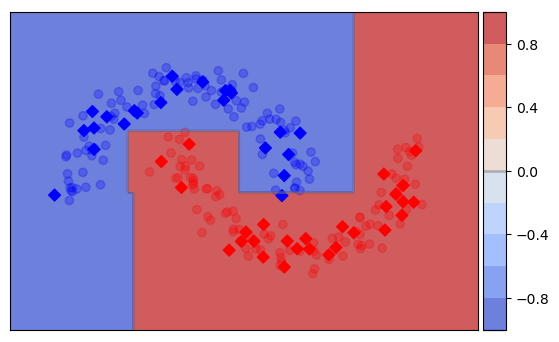

In [20]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_decision_surface(X_train, y_train, X_test, y_test, dt)

#### Part 1: Why is the decision tree model a good fit for this dataset?

**Excellent Performance on metrics:**

- Training Metrics: All metrics are at 100% (accuracy, precision, recall), which indicates that the model perfectly captures the training data.
- Testing Metrics: High test accuracy (98%) and perfect recall suggest that the model generalizes well to unseen data, capturing the structure of the dataset effectively.

**Explanation:**

- Non-Linear Data: The make_moons dataset has a non-linear structure. Decision trees are capable of handling non-linear relationships because they partition the feature space into distinct regions based on thresholds.
- Flexible Boundaries: Decision trees can create complex, non-linear decision boundaries, which align better with the curved shapes of the data, unlike logistic regression's linear boundary.

#### Part 2: Why is the decision boundary of the decision tree seems a heavyside step function? Does this structure contribute to overfitting or underfitting, and can you observe these issues in specific regions of the data?

- **Splitting the feature space into rectangular regions:** Each split is an axis-aligned decision boundary (either horizontal or vertical), so the resulting decision boundary appears jagged and box-like, creating a staircase pattern.

- **Contributing to Overfitting:** This structure can contribute to overfitting, especially if the tree depth is too high. The perfect 100% accuracy on the training set suggests that this decision tree might be overfitting. However we do not know unless we simulate if the tree has shallower layers below:

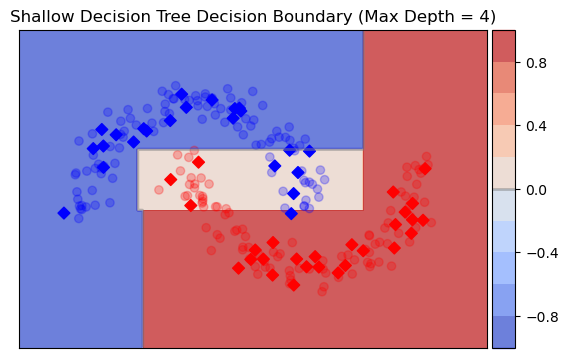

Shallow Tree Training Accuracy: 0.91
Shallow Tree Testing Accuracy: 0.88


In [21]:
# Fit a shallower decision tree with max depth of 4 to reduce overfitting
dt_shallow = DecisionTreeClassifier(max_depth=4)
dt_shallow.fit(X_train, y_train)

train_accuracy_shallow = accuracy_score(y_train, dt_shallow.predict(X_train))
test_accuracy_shallow = accuracy_score(y_test, dt_shallow.predict(X_test))

plot_decision_surface(X_train, y_train, X_test, y_test, dt_shallow, title="Shallow Decision Tree Decision Boundary (Max Depth = 4)")

# Display shallow tree results
print(f"Shallow Tree Training Accuracy: {train_accuracy_shallow}")
print(f"Shallow Tree Testing Accuracy: {test_accuracy_shallow}")

- **Conclusion on Overfitting:** Both original decision tree and this shallow tree above has training accuracy (1.0 and 0.91) higher than test accuracy (0.98 and 0.88) respectively. While this suggests overfitting, it may be true that the original deeper tree is fits the data structure better than the shallow tree because of the higher training (1.0 > 0.91) and test accuracy (0.98 > 0.88) and it is supported by the visualization as well.

#### Part 3: How do the decision boundaries produced by decision trees differ from those of logistic regression, particularly when dealing with nonlinear patterns?

- **Decision Trees:** Decision trees create boundaries that are axis-aligned, resulting in a step-like structure. These boundaries can capture non-linear patterns because they partition the space based on feature thresholds, producing blocky 'neighbourhoods' in a feature space.

- **Logistic Regression:** Logistic regression creates a single, linear decision boundary. It’s best suited for linearly separable data, and it cannot model non-linear relationships without transformations.

- **Impact on Nonlinear Data:** On a dataset like make_moons, decision trees have a distinct advantage because they can adjust their boundaries to fit the curved structure. Logistic regression, in contrast, fails to capture this structure, resulting in poor performance near the class overlap.

#### Part 4: What are the strengths and weaknesses of decision trees compared to logistic regression?

Main Strengths of Trees vs LogReg:
1. Sensitive to Non-Linear Data through segregation of neighbourhoods in the feature space, while to deploy LogReg requires some linear transformation
2. With plotting of decision boundary, provides high interpretability to business stakeholders
3. Insensitive to Scaling: Trees split data based on feature values (neighbourhoods), independent of other features’ range of values unlike LogReg which calculates distance between data points. Since they look only at whether a feature is greater or less than a threshold, the actual scale of features doesn’t affect the tree structure or the splits.

Main Weaknesses of Trees vs LogReg:
1. High Overfitting Tendency, meaning that if there is no tree pruning/ setting of maximum depth for the tree branches, trees may be unable to generalize seen data onto predicting unseen data


<div class="alert alert-info"><b>Exercise 6: Support vector machine model creation </b>

Write code to fit a Support Vector Machine (SVM) classifier with an RBF kernel to the training data and store the model in a variable named `svm`. Then, calculate the accuracy, precision, recall, and F1-score for both the training and testing sets, storing the results in the following variables: `train_accuracy`, `train_precision`, `train_recall`, `test_accuracy`, `test_precision`, `test_recall`, and `test_f1`.

<br><i>[0.5 points]</i>
</div>


In [22]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train, y_train)

y_train_pred = svm.predict(X_train)
y_test_pred = svm.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Display the results
print(f"Training Accuracy: {train_accuracy}")
print(f"Training Precision: {train_precision}")
print(f"Training Recall: {train_recall}")
print(f"Testing Accuracy: {test_accuracy}")
print(f"Testing Precision: {test_precision}")
print(f"Testing Recall: {test_recall}")
print(f"Testing F1 Score: {test_f1}")

Training Accuracy: 1.0
Training Precision: 1.0
Training Recall: 1.0
Testing Accuracy: 1.0
Testing Precision: 1.0
Testing Recall: 1.0
Testing F1 Score: 1.0


DO NOT TOUCH BELOW

In [23]:
# LEAVE BLANK

In [24]:
# LEAVE BLANK

In [25]:
# LEAVE BLANK

In [26]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 7: Explain the  support vector machine model decision boundary</b>

Provide well-reasoned answers to the following questions:

- Why is the SVM a good fit for this dataset?
- How do support vectors determine the decision boundary, and what impact does this have on the model's effectiveness?
- Why does the SVM produce a smooth, continuous decision boundary, unlike the 'blocky' boundaries seen in decision trees?
- How do the decision boundaries of SVM differ from the linear boundaries of logistic regression?
- What are the strengths and weaknesses of SVM compared to logistic regression and decision trees?
- In what scenarios might logistic regression be more suitable, and when would SVM be a better choice?
- How do support vectors shape the SVM's decision boundary, and how does this differ from the recursive partitioning method used by decision trees?

<br><i>[1 points]</i>
</div>

DO NOT TOUCH BELOW

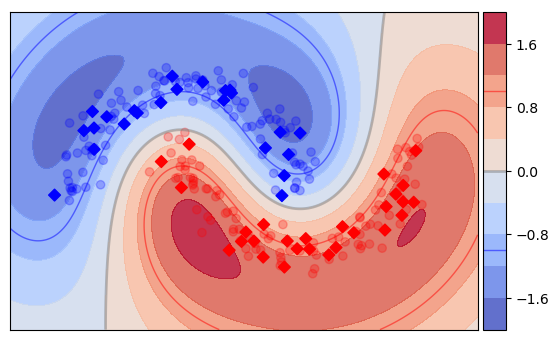

In [27]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_decision_surface(X_train, y_train, X_test, y_test, svm)

#### Part 1: Why is SVM a good fit?

**Using Visualization above:**
- SVM can create non-linear decision boundaries, likely because of the parameter of the RBF kernel transforming data into a higher-dimensional space where it becomes linearly separable.
- High Accuracy and F1 Scores: The high performance across all metrics suggests that the SVM is capturing the complex structure of the data very well without significant misclassifications.

#### Part 2: How do support vectors determine the decision boundary, and what impact does this have on the model's effectiveness?

**Using visualization above:**
- Support Vectors: In SVM, only training data that determines the decision boundary are used, also known as the support vectors. These support vectors are also the ones that lie closest to the boundary and are the relevant and critical points that would be considered to define the maximum-margin hyperplane.

- Impact: Using only support vectors to define the boundary makes the SVM robust to irrelevant data points. This allows it to generalize well, focusing on critical points near the boundary rather than all data points. This characteristic enhances the model's effectiveness, particularly in non-linear cases, as it creates a boundary based on critical instances.

#### Part 3: Why does the SVM produce a smooth, continuous decision boundary, unlike the 'blocky' boundaries seen in decision trees?

**Using Visualization from Decision Tree and SVM:**
- **Smooth Boundary in SVM:** SVM optimizes a mathematical function that maximizes the margin around the support vectors. This results in a boundary that smoothly separates the classes, rather than creating rigid, axis-aligned partitions.

- **Contrast with 'blocky Decision Trees:** Decision trees split data at each layer using threshold-based rules that translate into each feature in a feature space. Repeating this splitting processes down the tree layers, the tree classifies data from each split that results in rectangular "blocky" regions in a feature space.

#### Part 4: How do the decision boundaries of SVM differ from the linear boundaries of logistic regression?

**Using Visualisation of Decision Boundaries above:**

- **SVM:** SVM creates decision boundaries that capture complex structures in the data by transforming it into a higher-dimensional space where it becomes separable.
- **Logistic Regression:** Logistic regression can only create a linear decision boundary that separate classes with a straight line, which is insufficient for non-linear patterns like make_moons.

#### Part 5: What are the strengths and weaknesses of SVM compared to logistic regression and decision trees?

**Using Visualization of Decision Boundaries above:**
Main Strengths of SVM vs LogReg/Trees:
1. SVM helps to handle non-linear patterns due to robust decision boundaries defined by support vectors that can be smoothened to separate data class. This handling of non-linear patterns cannot be done with decision trees.

Main Weaknesses of SVM vs LogReg/Trees:
1. Business stakeholders sometimes want interpretability of results when it comes to classification problems. Logistic Regression can be easily explained when it comes to fitting data into a structure and explaining model optimization in penalizing errors. However, with SVM it is more difficult to help stakeholder interpret error loss and optimization with complex boundaries.

#### Part 6: Choosing between LogReg and SVM with RBF Kernel:

- **Logistic Regression:** Suitable for linearly separable data or when interpretability is critical especially to business stakeholders, as it’s easier to understand and interpret a linear boundary.

- **SVM with RBF Kernel:** Ideal for non-linear and complex datasets where a linear boundary cannot separate the classes effectively.
Preferred when maximizing classification margin is important, as SVM focuses on maximizing the separation between classes using support vectors.

#### Part 7: How do support vectors shape the SVM's decision boundary, and differ from the recursive partitioning method used by decision trees:

**Using Visualization of Decision boundaries above:**
- In SVM, the decision boundary is shaped by only the support vectors—the points closest to the decision boundary on either side. These points maximize the margin and define the position of the boundary.
- In Trees, each split is made independently, and all data points contribute to the formation of the boundary, leading to potentially complex, blocky boundaries that follow the shape of the data more directly.

<div class="alert alert-info"><b>Exercise 8: Generating a Noisy Dataset</b>

The dataset used in the previous exercies had an easy and well-defined decision boundary. However, real business datasets contains noise and errors, making the classification task more complex and intrincate. To generate a more realistic dataset, write code to generate a new feature matrix `X` and a target array `y` using the `make_moons` function with the parameters: `n_samples=250`, `noise=0.4`, and `random_state=42`. Then, split the generated dataset into training and testing sets, allocating 80% of the data for training and 20% for testing. Use `random_state=42` to ensure reproducibility. Store the resulting arrays in `X_train`, `X_test`, `y_train`, and `y_test`. Finally, call again `plot_decision_surface(X_train, y_train, X_test, y_test)` to visualize the new train and test data distribution.

<br><i>[0.25 points]</i>
</div>

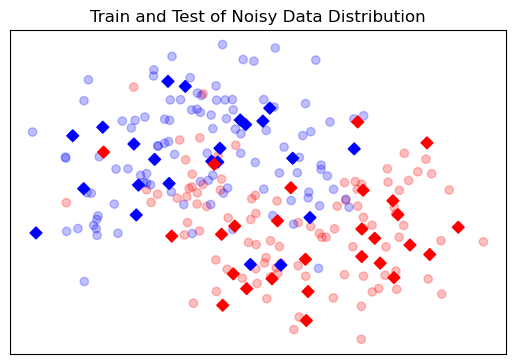

In [28]:
X, y = make_moons(n_samples=250, noise=0.4, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plot_decision_surface(X_train, y_train, X_test, y_test, title="Train and Test of Noisy Data Distribution")

DO NOT TOUCH BELOW

In [29]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 9: Analyzing the potential negative impact of noisy datasets</b>

Provide well-supported answers to the following questions:

- How do you think increased noise in the dataset will impact model performance? Which model do you expect to handle noise best, and why?
- How might the logistic regression model be affected by noisy data?
- How do you think noise will influence the decision tree model? Will the step-like characteristic of the boundaries of decision trees become more irregular or over-complicated due to noise? How might this affect performance, especially on unseen data?
- How will the SVM's decision boundary be influenced by noisy data? Do you expect SVM to become more sensitive to noisy data points near the boundary? How might this impact the margin, support vectors, and lead to overfitting or a reduction in margin width?
- What strategies can be used to mitigate the effects of noise on these models?

<br><i>[0.75 points]</i>
</div>

#### Part 1: How do you think increased noise in the dataset will impact model performance? Which model do you expect to handle noise best, and why?

**General Impact of Noise:** Increased noise in the dataset generally leads to reduced model performance because it introduces randomness and makes the decision boundary less clear. Models that are more flexible, like decision trees, may overfit by trying to capture noisy patterns.

**Model Sensitivity to Noise:**
1. **Logistic Regression:** Likely to handle noise better than decision trees and SVM due to its simplicity. As a linear model, it won’t overfit the noise as much. However because of the low complexity of linear qualities of the logistic regression model, it may still not capture the underlying patterns of data well.
2. **Decision Tree:** Likely to overfit, especially if it’s allowed to grow deep layers, as it may attempt to capture noisy patterns and produce a highly irregular, step-like boundary.
3. **SVM:** May be sensitive to noise near the decision boundary, as noisy points close to the boundary will impact support vectors and may reduce the margin.

**Expected Best Performer:** Logistic regression may handle noise better because it doesn’t attempt to fit complex, non-linear boundaries, making it more robust to random variations in the data.

#### Part 2: How might the logistic regression model be affected by noisy data?

We’ll fit logistic regression to the noisy data and calculate performance metrics for both the training and test sets. We expect logistic regression to achieve lower accuracy and F1 scores on the noisy data compared to the original dataset because noise makes the linear decision boundary less effective.

In [30]:
# Fit logistic regression on noisy data
logistic_noisy = LogisticRegression(random_state=42)
logistic_noisy.fit(X_train, y_train)

# Predictions and metrics
train_pred_logistic = logistic_noisy.predict(X_train)
test_pred_logistic = logistic_noisy.predict(X_test)

train_accuracy_logistic = accuracy_score(y_train, train_pred_logistic)
test_accuracy_logistic = accuracy_score(y_test, test_pred_logistic)
test_f1_logistic = f1_score(y_test, test_pred_logistic)

# Print results
print(f"Logistic Regression Training Accuracy: {train_accuracy_logistic}")
print(f"Logistic Regression Testing Accuracy: {test_accuracy_logistic}")
print(f"Logistic Regression Testing F1 Score: {test_f1_logistic}")

Logistic Regression Training Accuracy: 0.8
Logistic Regression Testing Accuracy: 0.86
Logistic Regression Testing F1 Score: 0.8727272727272727


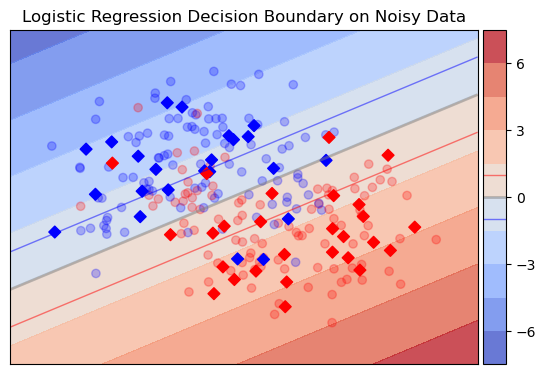

In [31]:
plot_decision_surface(X_train, y_train, X_test, y_test, logistic_noisy, title="Logistic Regression Decision Boundary on Noisy Data")

#### Part 3: How do you think noise will influence the decision tree model? Will the step-like characteristic of the boundaries of decision trees become more irregular or over-complicated due to noise? How might this affect performance, especially on unseen data?

We expect the decision tree to achieve near-perfect accuracy on the training data but to struggle on the test data due to overfitting. This is because it may create an overly complex, irregular boundary that captures noise as well as the underlying pattern.

The plot below will show a highly irregular, "blocky" boundary that attempts to fit the noise, especially in high-noise areas, leading to reduced generalization on test data.

In [32]:
# Fit decision tree on noisy data
dt_noisy = DecisionTreeClassifier(random_state=42)
dt_noisy.fit(X_train, y_train)

# Predictions and metrics
train_pred_dt = dt_noisy.predict(X_train)
test_pred_dt = dt_noisy.predict(X_test)

train_accuracy_dt = accuracy_score(y_train, train_pred_dt)
test_accuracy_dt = accuracy_score(y_test, test_pred_dt)
test_f1_dt = f1_score(y_test, test_pred_dt)

# Display results
print(f"Decision Tree Training Accuracy: {train_accuracy_dt}")
print(f"Decision Tree Testing Accuracy: {test_accuracy_dt}")
print(f"Decision Tree Testing F1 Score: {test_f1_dt}")

Decision Tree Training Accuracy: 1.0
Decision Tree Testing Accuracy: 0.78
Decision Tree Testing F1 Score: 0.8070175438596491


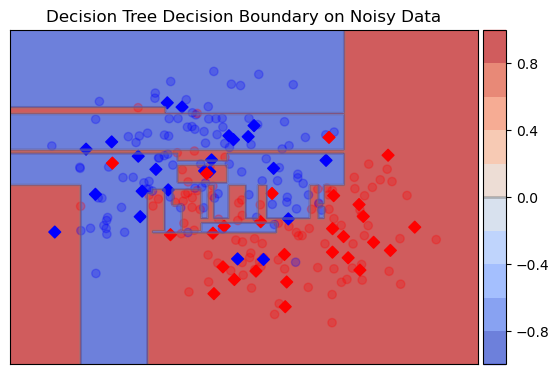

In [33]:
plot_decision_surface(X_train, y_train, X_test, y_test, dt_noisy, title="Decision Tree Decision Boundary on Noisy Data")

#### Part 4: How will the SVM's decision boundary be influenced by noisy data? Do you expect SVM to become more sensitive to noisy data points near the boundary? How might this impact the margin, support vectors, and lead to overfitting or a reduction in margin width?

- SVM may become more sensitive to noisy data near the boundary. Noisy points close to the boundary can be misclassified, affecting the support vectors and potentially reducing the margin width in below visualization.
- The SVM may overfit, focusing too much on noisy points rather than the true structure.

The plot below shows how noise affects the SVM's boundary: a more irregular boundary, influenced by noisy support vectors.

In [34]:
# Fit SVM on noisy data
svm_noisy = SVC(kernel='rbf', random_state=42)
svm_noisy.fit(X_train, y_train)

# Predictions and metrics
train_pred_svm = svm_noisy.predict(X_train)
test_pred_svm = svm_noisy.predict(X_test)

train_accuracy_svm = accuracy_score(y_train, train_pred_svm)
test_accuracy_svm = accuracy_score(y_test, test_pred_svm)
test_f1_svm = f1_score(y_test, test_pred_svm)

# Print results
print(f"SVM Training Accuracy: {train_accuracy_svm}")
print(f"SVM Testing Accuracy: {test_accuracy_svm}")
print(f"SVM Testing F1 Score: {test_f1_svm}")

SVM Training Accuracy: 0.855
SVM Testing Accuracy: 0.86
SVM Testing F1 Score: 0.8679245283018868


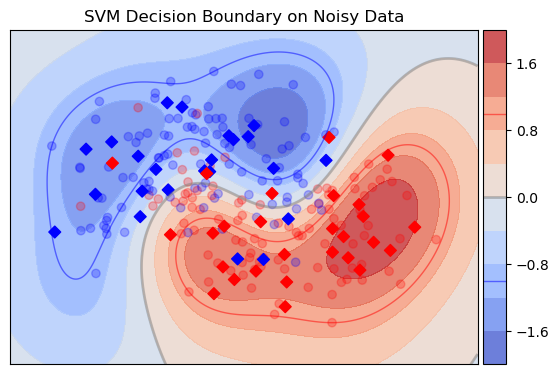

In [35]:
plot_decision_surface(X_train, y_train, X_test, y_test, svm_noisy, title="SVM Decision Boundary on Noisy Data")


#### Part 5: What strategies can be used to mitigate the effects of noise on these models?

1. **Logistic Regression:** Adding regularization term to prevent the model from fitting noise.

2. **Decision Trees:** Setting a maximum depth (e.g., max_depth=5) can reduce overfitting by preventing the model from creating overly specific boundaries.

3. **SVM:** Adjust Parameters such as Gamma or C: 

- Gamma defines how far the influence of a single data point reaches. Reducing the gamma parameter allows SVM to create a larger margin by allowing some misclassifications. This can help the model ignore noisy data points that lie near the boundary.

- C controls the trade-off between a large margin and classification accuracy. Reducing C allows more misclassifications for a smoother, more generalized boundary, thus reducing overfitting.

<div class="alert alert-info"><b>Exercise 10: Adding a regularization term</b>

Now, it's time to explore the impact of hyperparameters on model performance. To understand the role of the `gamma` hyperparameter in SVM models, refer to [this resource](https://amagash.github.io/pages/exploration/supervised-learning/svm.html). Additionally, for a general understanding of regularization in supervised learning and SVMs in particular, check out these links: [Simplilearn's guide on regularization](https://www.simplilearn.com/tutorials/machine-learning-tutorial/regularization-in-machine-learning) and [Wikipedia's overview](https://en.wikipedia.org/wiki/Regularization_perspectives_on_support_vector_machines).

Your task is to write a function called `get_metrics(model, X, y)`, where the first parameter is a pre-trained model, `X` is the feature matrix, and `y` is the target array. This function should return a dictionary containing key-value pairs for the following metrics: accuracy, precision for class 0 and class 1, recall for class 0 and class 1, and F1-score for class 0 and class 1. The dictionary should be structured as follows:

```python
{
   'accuracy': accuracy, 
   'precision_class_0': precision_class_0, 
   'precision_class_1': precision_class_1, 
   'recall_class_0': recall_class_0, 
   'recall_class_1': recall_class_1, 
   'f1_class_0': f1_class_0, 
   'f1_class_1': f1_class_1
}
```

Next, train three SVM models using the following values for the `gamma` parameter: `0.01`, `'scale'`, and `100`, while keeping the other hyperparameters at their default values. Store these models in a dictionary called `svm_models`, where each key is the corresponding `gamma` value and the value is the trained model. Use the function `get_metrics(model, X, y)` to generate two DataFrames `train_metrics`, and `test_metrics` to store performance metrics and its corresponding `gamma` value. Finally, find the model with the highest accuracy and store it in a variable called `best_svm`.

<br><i>[1 points]</i>
</div>

In [36]:
import pandas as pd

def get_metrics(model, X, y):
    y_pred = model.predict(X)
    
    accuracy = accuracy_score(y, y_pred)
    
    precision_class_0 = precision_score(y, y_pred, pos_label=0)
    precision_class_1 = precision_score(y, y_pred, pos_label=1)
    recall_class_0 = recall_score(y, y_pred, pos_label=0)
    recall_class_1 = recall_score(y, y_pred, pos_label=1)
    f1_class_0 = f1_score(y, y_pred, pos_label=0)
    f1_class_1 = f1_score(y, y_pred, pos_label=1)
    
    metrics = {
        'accuracy': accuracy,
        'precision_class_0': precision_class_0,
        'precision_class_1': precision_class_1,
        'recall_class_0': recall_class_0,
        'recall_class_1': recall_class_1,
        'f1_class_0': f1_class_0,
        'f1_class_1': f1_class_1
    }
    return metrics
   
gamma_values = [0.01, 'scale', 100]
svm_models = {}

for gamma in gamma_values:
    model = SVC(kernel='rbf', gamma=gamma, random_state=42)
    model.fit(X_train, y_train)
    svm_models[gamma] = model

train_metrics_list = []
test_metrics_list = []

for gamma, model in svm_models.items():
    train_metric = get_metrics(model, X_train, y_train)
    train_metric['gamma'] = gamma 
    train_metrics_list.append(train_metric)
    
    test_metric = get_metrics(model, X_test, y_test)
    test_metric['gamma'] = gamma 
    test_metrics_list.append(test_metric)


# Display the results
train_metrics = pd.DataFrame(train_metrics_list)
test_metrics = pd.DataFrame(test_metrics_list)

print("Training Metrics:")
display(train_metrics)
print("Testing Metrics:")
display(test_metrics)


# Find the gamma value with the highest test accuracy
best_gamma = test_metrics.loc[test_metrics['accuracy'].idxmax()]['gamma']

best_svm_metrics = test_metrics[test_metrics['gamma'] == best_gamma]
best_svm = svm_models[best_gamma]

# Display the best model's gamma value
print("Best gamma value based on test accuracy:", best_gamma)
best_svm_metrics

Training Metrics:


,accuracy,precision_class_0,precision_class_1,recall_class_0,recall_class_1,f1_class_0,f1_class_1,gamma
0,0.775,0.766355,0.784946,0.803922,0.744898,0.784689,0.764398,0.01
1,0.855,0.868687,0.841584,0.843137,0.867347,0.855721,0.854271,scale
2,0.975,0.961905,0.989474,0.990196,0.959184,0.975845,0.974093,100


Testing Metrics:


,accuracy,precision_class_0,precision_class_1,recall_class_0,recall_class_1,f1_class_0,f1_class_1,gamma
0,0.84,0.857143,0.827586,0.782609,0.888889,0.818182,0.857143,0.01
1,0.86,0.833333,0.884615,0.869565,0.851852,0.851064,0.867925,scale
2,0.70,0.681818,0.714286,0.652174,0.740741,0.666667,0.727273,100


Best gamma value based on test accuracy: scale


,accuracy,precision_class_0,precision_class_1,recall_class_0,recall_class_1,f1_class_0,f1_class_1,gamma
1,0.86,0.833333,0.884615,0.869565,0.851852,0.851064,0.867925,scale


DO NOT TOUCH BELOW

In [37]:
# LEAVE BLANK

In [38]:
# LEAVE BLANK

In [39]:
# LEAVE BLANK

In [40]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 11: Explain SVM regularization effect</b>

Provide well-reasoned answers to the following questions:

- How does adjusting the `gamma` parameter impact the model’s complexity? Which values of `gamma` produce a smoother, more generalized decision boundary, and how does this affect the model's ability to handle noise? Conversely, which values result in a more complex decision boundary that may overfit the data, including noise?
- Can you pinpoint regions where overfitting or underfitting occurs based on the different `gamma` values?
- How do precision and recall vary as you change the `gamma` parameter? Does a higher `gamma` lead to better precision at the expense of recall, or the opposite?
- How do the test set metrics compare to the training set metrics for different `gamma` values? 
- Based on these observations, which model would you select, and why?
- What modifications could be made to improve the chosen model's performance on the noisy dataset?

<br><i>[1 points]</i>
</div>

DO NOT TOUCH BELOW

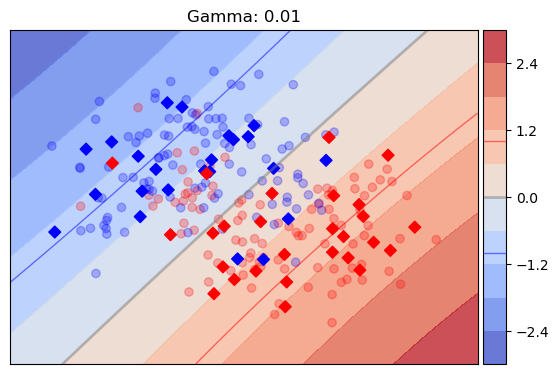

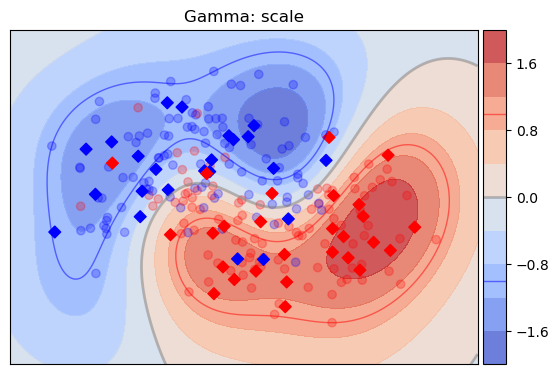

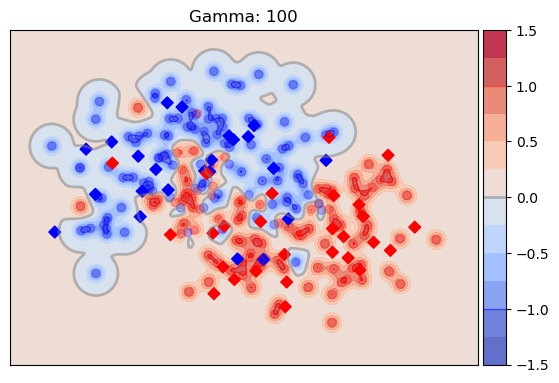

In [41]:
# DO NOT MODIFY THIS CELL. Simply execute it.
for svm in svm_models.values():
    plot_decision_surface(X_train, y_train, X_test, y_test, svm, title=f'Gamma: {svm.gamma}')

In [42]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_parallel_coordinates(train_metrics, svm_models, 'Train metrics')
plot_parallel_coordinates(test_metrics, svm_models, 'Test metrics')


#### Part 1: How does adjusting the gamma parameter impact the model’s complexity? Which values of gamma produce a smoother, more generalized decision boundary, and how does this affect the model's ability to handle noise? Conversely, which values result in a more complex decision boundary that may overfit the data, including noise?

1. **Model Complexity:** Higher gamma values (e.g. those close to 100) create a more complex decision boundary, as the model only considers points very close to the decision boundary, This can lead to overfitting, where the model captures not only the underlying structure but also the noise in the data.
2. **Smoother decision boundary**: Lower gamma values (e.g. those at 'scale') result in a smoother, more generalized decision boundary. This is because lower gamma values mean that the model considers points farther away from the decision boundary. As a result, the decision surface is less sensitive to individual points, which helps the model generalize better and handle noise more effectively.

#### Part 2: Can you pinpoint regions where overfitting or underfitting occurs based on the different gamma values?

1. **Gamma = 0.01 (Underfitting):**

- Observation: The decision boundary is very smooth and almost linear. It doesn't capture the curved structure of the data well and generalizes too much. This low gamma value leads to underfitting, especially in complex regions, as the model is not able to capture detailed patterns.
- Regions of Underfitting: In the overlapping areas where the two classes are intertwined (e.g., the inner sections of each "moon" shape), the boundary does not capture the data’s complexity. This smooth, generalized boundary results in misclassifications in regions with high overlap, as it fails to adapt to the non-linear shape of the classes.

2. **Gamma = 'scale' (Good Fit):**

- Observation: The decision boundary is flexible enough to capture the curved structure of the data, but it remains smooth and does not overfit to individual data points. It follows the contours of each class without becoming overly intricate, striking a good balance between capturing the data's complexity and maintaining generalization.
- Good Fit in Most Regions: This boundary captures the underlying structure of the data well, balancing between underfitting and overfitting. It fits closely in areas where the two classes curve around each other, without adapting to individual noise points.

3. **Gamma = 100 (Overfitting):**

- Observation: The decision boundary is highly intricate, wrapping tightly around individual data points. This results in a "spiky" or highly irregular shape that mirrors noise in the dataset. This high gamma value leads to overfitting, as the model captures both the actual data structure and noise, creating a highly complex boundary that will likely perform poorly on unseen data.
- Regions of Overfitting: In areas with noisy data points or overlapping classes, the boundary adapts to even slight variations. This boundary captures noise, as it attempts to classify each point perfectly, leading to irregular regions that do not generalize well.

#### Part 3: How do precision and recall vary as you change the gamma parameter? Does a higher gamma lead to better precision at the expense of recall, or the opposite?

We can observe from the code below:

- **Low gamma:** Precision may be lower, as the model is less sensitive to capturing small details around the boundary, potentially missing points close to the boundary. Recall may be higher, as the model generalizes more, capturing a broader range of positive cases.
- **High gamma:** Precision may be higher due to the model capturing specific patterns, but recall could decrease because the model becomes selective, especially in regions where noise and data overlap.

In [43]:
# Display precision and recall for each gamma value on the test set
test_metrics[['gamma', 'precision_class_0', 'precision_class_1', 'recall_class_0', 'recall_class_1']]

,gamma,precision_class_0,precision_class_1,recall_class_0,recall_class_1
0,0.01,0.857143,0.827586,0.782609,0.888889
1,scale,0.833333,0.884615,0.869565,0.851852
2,100,0.681818,0.714286,0.652174,0.740741


#### Part 4: How do the test set metrics compare to the training set metrics for different gamma values?

Referring to the code cells below:

1. **Gamma = 0.01:** Underfitting is evident as both training and test accuracies are relatively low. Difference in Accuracy (Train-Test) = -0.065. This indicates the model can be more complext by still having a higher gamma value as the model is still generalizing well, with a higher Test Accuracy value.
2. **Gamma = 'scale':** This setting achieves a balanced model with minimal differences between training and test metrics, indicating a well-generalized model without overfitting. We can see this where Difference in Accuracy (Train-Test) = -0.005.
3. **Gamma = 100:** Severe overfitting is observed with a large gap between training and test accuracies. The model is too complex and fails to generalize well to the test set. We can see this where Difference in Accuracy (Train-Test) = +0.275.

In [44]:
# Display metrics for each gamma value on the training set:
train_metrics[['gamma', 'accuracy', 'precision_class_0', 'precision_class_1', 'recall_class_0', 'recall_class_1']]

,gamma,accuracy,precision_class_0,precision_class_1,recall_class_0,recall_class_1
0,0.01,0.775,0.766355,0.784946,0.803922,0.744898
1,scale,0.855,0.868687,0.841584,0.843137,0.867347
2,100,0.975,0.961905,0.989474,0.990196,0.959184


In [45]:
# Display metrics for each gamma value on the test set:
test_metrics[['gamma', 'accuracy', 'precision_class_0', 'precision_class_1', 'recall_class_0', 'recall_class_1']]

,gamma,accuracy,precision_class_0,precision_class_1,recall_class_0,recall_class_1
0,0.01,0.84,0.857143,0.827586,0.782609,0.888889
1,scale,0.86,0.833333,0.884615,0.869565,0.851852
2,100,0.70,0.681818,0.714286,0.652174,0.740741


#### Part 5: Based on these observations, which model would you select, and why?

- The model with gamma='scale' is likely the best choice, as it balances the complexity of the decision boundary with the ability to handle noise effectively.
- Quantitatively speaking, The difference between Accuracy (Train-Test) is the lowest which indicates the minima of the Test Data curve in the Bias-Variance Graph. This means this model is complex enough but still able to generalize to new unseen data.

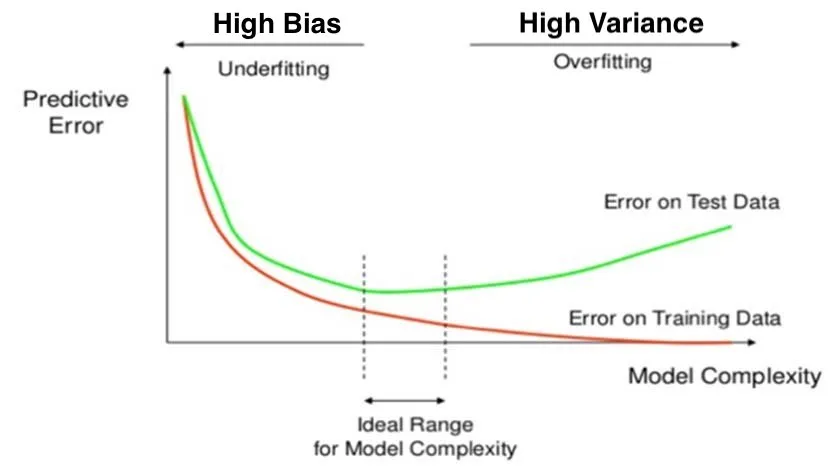

#### Part 6: What modifications could be made to improve the chosen model's performance on the noisy dataset?

**Using GridSearchCV:**
1. Firstly, it automates hyperparameter tuning by performing an exhaustive search over a specified parameter grid.
2, Secondly, it combines cross-validation with hyperparameter search, evaluating each combination of parameters (Gamma and C for SVM) to find the best set that maximizes model performance.

**Evaluating Parameters in the SVM:**
1. Gamma controls the influence of every single data point, with a higher gamma making the decision boundary less influenced by distant points.
2. Another unpoken parameter in SVM is 'C', where C controls the trade-off between maximizing the margin around the decision boundary and minimizing classification errors. A higher C means lower margin maximization and higher minimizing of classification errors.

The code below shall follow the steps:

**1. Define a Range of Hyperparameters:** Choose a set of values for gamma and C to search over. Start with a range that includes both low and high values to explore different levels of model complexity.

**2. Set Up GridSearchCV:** Use GridSearchCV to test each combination of gamma and C values using cross-validation. This will help you find the best parameters that generalize well to unseen, noisy data.

**3. Fit and Evaluate the Best Model:** GridSearchCV will return the model with the best cross-validated score. You can then fit this model on the entire training dataset and evaluate it on the test set to check its performance.

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define parameter grid with a range of `gamma` and `C` values
param_grid = {
    'gamma': [0.01, 0.1, 1, 'scale', 10, 100],
    'C': [0.1, 1, 10, 100]
}

# Set up GridSearchCV with SVM and the parameter grid
grid_search = GridSearchCV(SVC(kernel='rbf', random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model and parameters from GridSearchCV
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)

# Evaluate the best model on the test set
best_svm = grid_search.best_estimator_
test_accuracy = best_svm.score(X_test, y_test)
print("Test accuracy of the best model:", test_accuracy)


Best parameters: {'C': 10, 'gamma': 'scale'}
Best cross-validated accuracy: 0.85
Test accuracy of the best model: 0.82


<div class="alert alert-info"><b>Exercise 12: Increase size of dataset</b>

Now, let's retrain the least regularized SVM model with `gamma` set to 100, but this time using a larger dataset. Generate the dataset using the `make_moons` function with the parameters: `n_samples=2500`, `noise=0.4`, and `random_state=42`. Next, split the dataset into training and testing sets, with 80% of the data for training and 20% for testing, ensuring reproducibility by using `random_state=42`. Store the resulting arrays as `X_train`, `X_test`, `y_train`, and `y_test`.

Fit the SVM model using the training data and store it in a variable called `non_regularized_svm`. Then, use the `get_metrics` function to compute the performance metrics, as done in the previous exercise, and append the results to the `train_metrics` and `test_metrics` dataframes.

Finally, add a new column named `dataset_size` to the metrics dataframes, assigning a value of `2500` for the new `non_regularized_svm` model and `250` for the previous models.

<br><i>[1 points]</i>
</div>

In [47]:
# Generate the larger dataset with 2500 samples
X, y = make_moons(n_samples=2500, noise=0.4, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the SVM model with gamma=100 which is also the least regularized
non_regularized_svm = SVC(kernel='rbf', gamma=100).fit(X_train, y_train)

train_metrics_large = get_metrics(non_regularized_svm, X_train, y_train)
test_metrics_large = get_metrics(non_regularized_svm, X_test, y_test)

# Add gamma and dataset_size columns and convert to Dataframes:
train_metrics_large['gamma'] = 100
train_metrics_large['dataset_size'] = 2500
test_metrics_large['gamma'] = 100
test_metrics_large['dataset_size'] = 2500

train_metrics_large_df = pd.DataFrame([train_metrics_large])
test_metrics_large_df = pd.DataFrame([test_metrics_large])

pd.set_option('display.max_columns', None)

# Append to existing metrics DataFrames (assuming train_metrics and test_metrics already exist)
train_metrics = pd.concat([train_metrics, train_metrics_large_df], ignore_index=True)
test_metrics = pd.concat([test_metrics, test_metrics_large_df], ignore_index=True)

# Step 6: Update existing models' metrics with dataset size for consistency
train_metrics.loc[train_metrics['dataset_size'].isnull(), 'dataset_size'] = 250
test_metrics.loc[test_metrics['dataset_size'].isnull(), 'dataset_size'] = 250

In [48]:
train_metrics

,accuracy,precision_class_0,precision_class_1,recall_class_0,recall_class_1,f1_class_0,f1_class_1,gamma,dataset_size
0,0.775,0.766355,0.784946,0.803922,0.744898,0.784689,0.764398,0.01,250.0
1,0.855,0.868687,0.841584,0.843137,0.867347,0.855721,0.854271,scale,250.0
2,0.975,0.961905,0.989474,0.990196,0.959184,0.975845,0.974093,100,250.0
3,0.886,0.880881,0.891109,0.889788,0.882295,0.885312,0.886680,100,2500.0


In [49]:
test_metrics

,accuracy,precision_class_0,precision_class_1,recall_class_0,recall_class_1,f1_class_0,f1_class_1,gamma,dataset_size
0,0.840,0.857143,0.827586,0.782609,0.888889,0.818182,0.857143,0.01,250.0
1,0.860,0.833333,0.884615,0.869565,0.851852,0.851064,0.867925,scale,250.0
2,0.700,0.681818,0.714286,0.652174,0.740741,0.666667,0.727273,100,250.0
3,0.852,0.869565,0.834008,0.842912,0.861925,0.856031,0.847737,100,2500.0


DO NOT TOUCH BELOW

In [50]:
# LEAVE BLANK

In [51]:
# LEAVE BLANK


In [52]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 13: Explain size of dataset</b>

Provide well-reasoned answers to the following questions:

- How does increasing the dataset size help to reduce overfitting and improve the model’s test performance?
- As more data is added, how does the SVM's decision boundary become smoother, allowing the model to generalize better and avoid fitting to noise?
- How do the test metrics (such as accuracy, precision, and recall) improve in relation to the training metrics as the dataset size grows?
- Is there a point where adding more data stops providing significant improvements in performance?
- Why does increasing the dataset size help counterbalance the high `gamma` value, thereby reducing overfitting?
- How does the increase in data help the model create a smoother decision boundary?
- Would you still consider lowering the `gamma` value, or is increasing the dataset size sufficient to address overfitting in this case?
- In which situations might increasing the dataset size alone not be enough to mitigate overfitting, and how could adjusting the `gamma` parameter help in such cases?
- After evaluating the effect of dataset size on overfitting, which model would you choose? Do you believe that increasing the dataset size sufficiently improves the performance of the high-`gamma` model, or would a lower-`gamma` model perform better for this dataset?"

  

<br><i>[1 points]</i>
</div>
<div class="alert alert-warning">

The `plot_decision_surface` function may take up to 30 seconds to complete. Please be patient, this is expected behavior.

</div>


DO NOT TOUCH BELOW

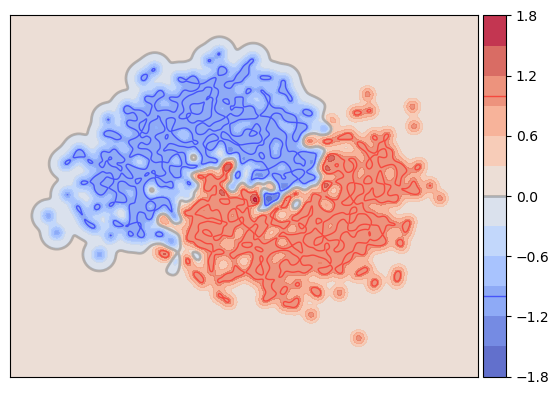

In [53]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_decision_surface(X_train, y_train, X_test, y_test, non_regularized_svm, show_points=False)

In [54]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_parallel_coordinates(train_metrics, svm_models, 'Train metrics')
plot_parallel_coordinates(test_metrics, svm_models, 'Test metrics')

#### Part 1: How does increasing the dataset size help to reduce overfitting and improve the model’s test performance?

- Overfitting occurs when a model learns the noise or specific details of a small dataset rather than the general pattern. As the dataset size increases, the model is exposed to more data points, reducing the chance of memorizing noise and making it easier to learn a general pattern. Hence, a larger dataset size helps the model generalize better on the test set, reducing overfitting.
- This can be shown in Part 3 when we compare the differences between metrics of (Train-Test) between SVM size=250 and SVM size=2500. 
- This can also be graphically shown where a less complex model has a lower x-value representing complexity: showing a smaller deviation between the training and test curve and smaller error towards the minima point

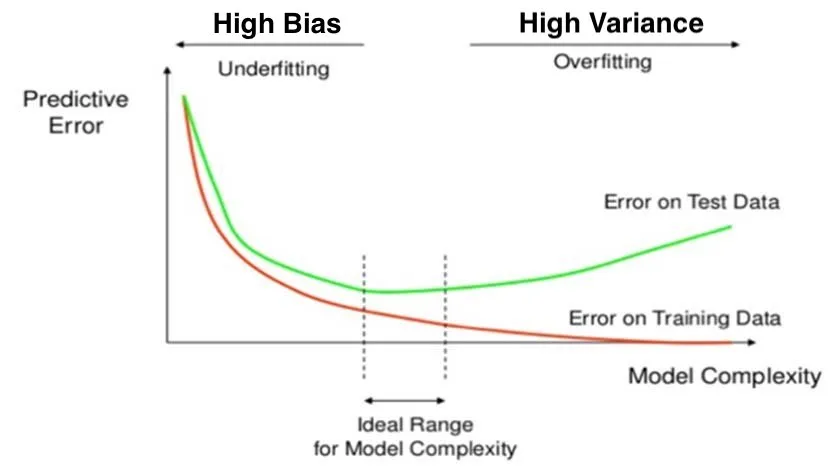

#### Part 2: As more data is added, how does the SVM's decision boundary become smoother, allowing the model to generalize better and avoid fitting to noise?

With more data, the SVM has a better estimate of the true distribution of each class. This makes the boundary smoother as it learns to focus on the overall pattern rather than individual noisy points. The decision boundary will better capture the general structure of the data rather than conforming to outliers or noise. We can see this point proven where in the model of size=2500, there are no red exclaves in the blue regions and blue exclaves in the red region anymore, showing better learning and generalization of underlying structure of data.

#### Visualization of gamma=100 and size=250
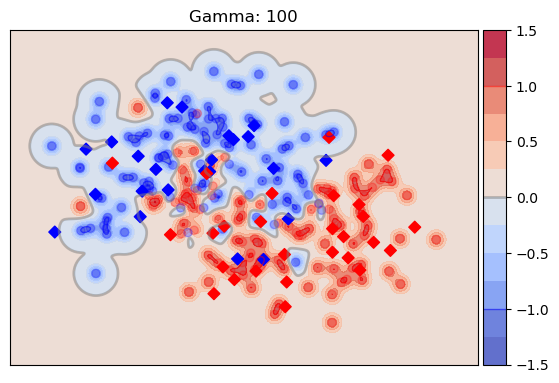

#### Visualization of gamma=100 and size=2500
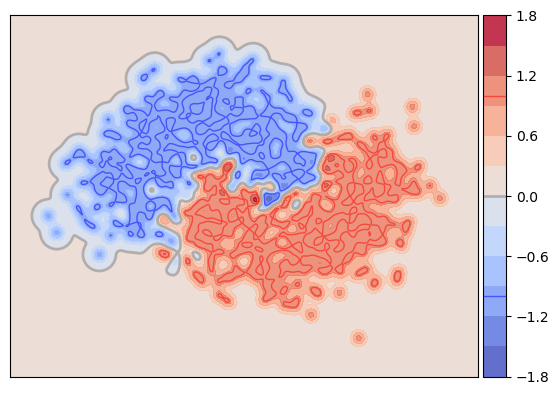

#### Part 3: How do the test metrics (such as accuracy, precision, and recall) improve in relation to the training metrics as the dataset size grows?

- Reusing the Bias-Variance graph from Part 1, as the dataset size grows, the gap between training and test metrics typically narrows. This reflects that the model is generalizing better and the overfitting issue is reduced.

- As we have compared **Accuracy** in Part 1, if we similarly examine the other metrics such as precision and recall for the larger dataset (2500 samples), we from the above we also see closer training and test metrics compared to the smaller dataset (250 samples).

- We find the comparisons below with code as proof:

In [55]:
# Calculate the differences between training and test metrics for rows 2 and 3
metrics_comparison = ['accuracy', 'precision_class_0', 'precision_class_1', 'recall_class_0', 'recall_class_1']

# Calculate the difference for each metric between train and test for rows 2 and 3
diff_row_2 = train_metrics.loc[2, metrics_comparison] - test_metrics.loc[2, metrics_comparison]
diff_row_3 = train_metrics.loc[3, metrics_comparison] - test_metrics.loc[3, metrics_comparison]

# Store the differences in a DataFrame for clear display
diff_df = pd.DataFrame({'Metrics Difference for 250 samples SVM': diff_row_2, 'Metrics Difference for 2500 samples SVM': diff_row_3})
diff_df

,Metrics Difference for 250 samples SVM,Metrics Difference for 2500 samples SVM
accuracy,0.275,0.034
precision_class_0,0.280087,0.011316
precision_class_1,0.275188,0.057101
recall_class_0,0.338022,0.046876
recall_class_1,0.218443,0.02037


**Conclusion:** The metrics for both class_0 and class_1 become more aligned between training and testing, showing that the model now captures the broader patterns rather than focusing on noise or specific details. This consistency across metrics (accuracy, precision, recall, and F1-score) for both classes indicates that the larger dataset improves generalization and balances performance across classes.

#### Part 4: Is there a point where adding more data stops providing significant improvements in performance?

From the below code and visualizations, we can see a diminishing return if we plot a graph showing Metrics (Accuracy) vs Dataset Size. Initially, increasing dataset size helps significantly, but eventually, the model stabilizes in performance as it has learned the underlying pattern of the data.

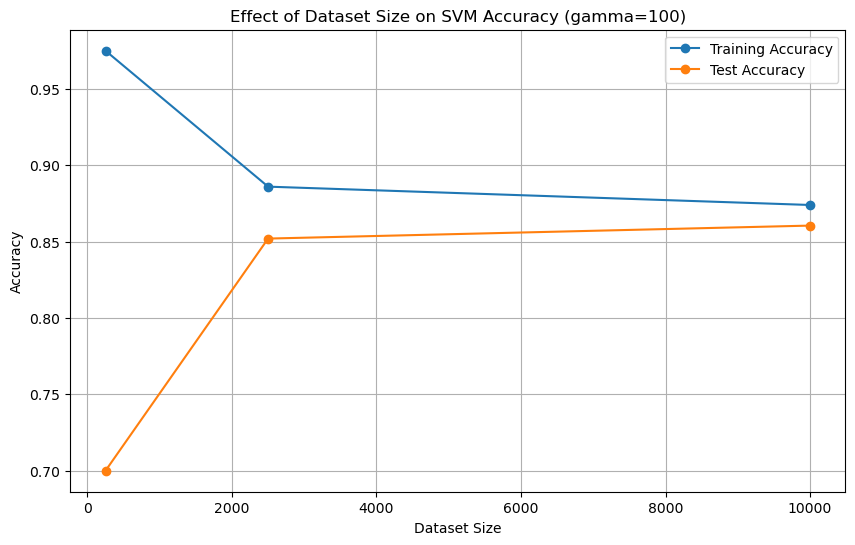

,dataset_size,train_accuracy,test_accuracy
0,250,0.975,0.7000
1,2500,0.886,0.8520
2,10000,0.874,0.8605


In [56]:
# Define a function to calculate and collect metrics for dataset size of 250, 2500, and 10000:
def train_svm_and_get_metrics(n_samples, gamma, random_state=42):

    X, y = make_moons(n_samples=n_samples, noise=0.4, random_state=random_state)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    svm_model = SVC(kernel='rbf', gamma=gamma, random_state=random_state)
    svm_model.fit(X_train, y_train)

    train_accuracy = svm_model.score(X_train, y_train)
    test_accuracy = svm_model.score(X_test, y_test)
    return {'dataset_size': n_samples, 'train_accuracy': train_accuracy, 'test_accuracy': test_accuracy}

# Intialize dataset sizes: 250, 2500, and 10000
dataset_sizes = [250, 2500, 10000]
gamma = 100
metrics_results = []

# Convert results to DataFrame:
for size in dataset_sizes:
    metrics_results.append(train_svm_and_get_metrics(n_samples=size, gamma=gamma))

metrics_df = pd.DataFrame(metrics_results)

# Plotting Accuracy against Dataset size:
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['dataset_size'], metrics_df['train_accuracy'], label="Training Accuracy", marker='o')
plt.plot(metrics_df['dataset_size'], metrics_df['test_accuracy'], label="Test Accuracy", marker='o')
plt.xlabel('Dataset Size')
plt.ylabel('Accuracy')
plt.title('Effect of Dataset Size on SVM Accuracy (gamma=100)')
plt.legend()
plt.grid(True)
plt.show()

metrics_df 

#### Part 5: Why does increasing the dataset size help counterbalance the high gamma value, thereby reducing overfitting?

- A high gamma value causes the model to focus on points close to the decision boundary, potentially fitting to noise. With more data, the model has more examples of points, making it less susceptible noise and helping it capture the general distribution better.
- This can be observed in the above graph plotted in Part 4.

#### Part 6: How does the increase in data help the model create a smoother decision boundary?

- Similar to Part 2's response and comparison of visualizations, more data points spread out over the feature space give the model a more accurate view of each class's distribution. 
- This enables the model to place a smoother boundary that respects the overall shape of the data,

#### Part 7, 8 9:

We shall adapt the train_svm_and_get_metrics function to include the scenario of providing gamma = 0.1, 10 and 100 in addition to size=250,2500,10000. Then we simulate the scenarios and compare respectively. Kindly see code below:

In [57]:
# Define a function to calculate and collect metrics for a given dataset size and gamma value
def train_svm_and_get_metrics(n_samples, gamma, random_state=42):

    X, y = make_moons(n_samples=n_samples, noise=0.4, random_state=random_state)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    svm_model = SVC(kernel='rbf', gamma=gamma, random_state=random_state)
    svm_model.fit(X_train, y_train)

    train_accuracy = svm_model.score(X_train, y_train)
    test_accuracy = svm_model.score(X_test, y_test)
    return {'dataset_size': n_samples, 'gamma': gamma, 'train_accuracy': train_accuracy, 'test_accuracy': test_accuracy}

# Test with dataset sizes of 250, 2500, and 10000 for 3 gamma values
dataset_sizes = [250, 2500, 10000]
gammas = [0.1, 10, 100]
metrics_results2 = []

# Collect metrics for each combination of dataset size and gamma
for gamma in gammas:
    for size in dataset_sizes:
        metrics_results2.append(train_svm_and_get_metrics(n_samples=size, gamma=gamma))

metrics_df2 = pd.DataFrame(metrics_results2)
metrics_df2['Difference (Train-Test)'] = metrics_df2['train_accuracy'] - metrics_df2['test_accuracy']

metrics_df2


,dataset_size,gamma,train_accuracy,test_accuracy,Difference (Train-Test)
0,250,0.1,0.795000,0.8400,-0.045000
1,2500,0.1,0.840000,0.8460,-0.006000
2,10000,0.1,0.850875,0.8635,-0.012625
3,250,10.0,0.865000,0.8400,0.025000
4,2500,10.0,0.870000,0.8640,0.006000
5,10000,10.0,0.865625,0.8685,-0.002875
6,250,100.0,0.975000,0.7000,0.275000
7,2500,100.0,0.886000,0.8520,0.034000
8,10000,100.0,0.874000,0.8605,0.013500


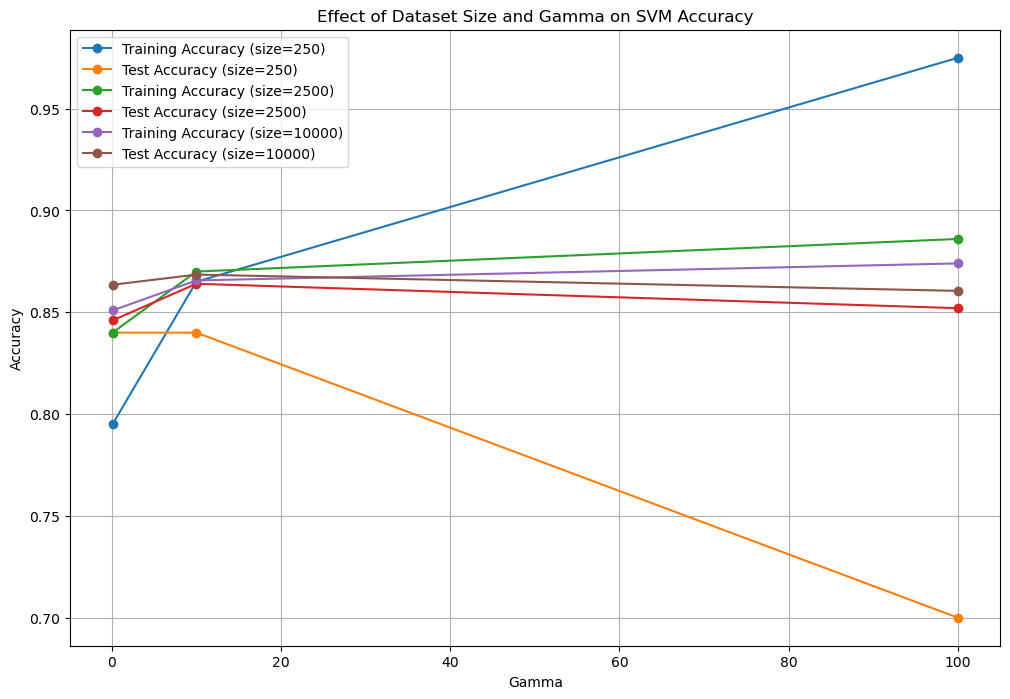

In [58]:
# Plotting accuracy against dataset size for each gamma value
plt.figure(figsize=(12, 8))
for size in dataset_sizes:
    subset = metrics_df2[metrics_df2['dataset_size'] == size]
    plt.plot(subset['gamma'], subset['train_accuracy'], label=f"Training Accuracy (size={size})", marker='o')
    plt.plot(subset['gamma'], subset['test_accuracy'], label=f"Test Accuracy (size={size})", marker='o')

plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.title('Effect of Dataset Size and Gamma on SVM Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#### Part 7: Would you still consider lowering the gamma value, or is increasing the dataset size sufficient to address overfitting in this case?

- From the above plotted graph, if gamma=100 and if the dataset is huge, there might be little point to lower the gamma value. Gamma has to be lowered in a large magnitude from 100 to 10, just to observe little improvement in accuracy.
- Generally from the above statistics and graph, increasing the dataset size is sufficient to address overfitting where Difference between Train and Test accuracy is reduced.
- However, increasing the dataset size is not always sufficient, as elaborated in Part 8.

#### Part 8: In which situations might increasing the dataset size alone not be enough to mitigate overfitting, and how could adjusting the gamma parameter help in such cases?

1. **Insufficient to increase the dataset size if:**
- The data is inherently noisy, as more data may amplify noise rather than provide clarity.
- The model complexity (due to high gamma) is too high and the decision boundary is too sensitive to individual points.


2. **Lowering gamma:** 
- Helps by making the boundary less complex and more generalized, preventing overfitting to noisy points.

#### Part 9: After evaluating the effect of dataset size on overfitting, which model would you choose? Do you believe that increasing the dataset size sufficiently improves the performance of the high-gamma model, or would a lower-gamma model perform better for this dataset?

- Since there is a positive relationship between gamma and datasize from the above statistics and graph, highest gamma=100 and highest datasize=10,000, gives the highest test accuracy as shown on the brown line.
- For the dataset in Exercise 11 and 12 where size=2500 and gamma=100, it is clear that high gamma may not help to improve model performance. However, choosing a lower gamma model only improves test performance (accuracy) by just a little from 0.8520 to 0.8640. Nevertheless, we still gain marginal improvement by choosing to reduce the gamma from 100 to 10 to achieve a higher test accuracy